<a href="https://colab.research.google.com/github/AmandaGamage/CV_Project/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ### EEE6503-01: Computer Vision

# Assignment \# 2: Mask R-CNN

**<div style="text-align: right"> Due date: Nov. 1st, 2024. </div>**
**<div style="text-align: right"> Please upload your file @ learnus by 9:00 PM. </div>**
<div style="text-align: right"> Lee Geon(이건): <a href="mailto:geon.lee@yonsei.ac.kr">geon.lee@yonsei.ac.kr</a>
<div style="text-align: right"> Sanghoon Lee(이상훈): <a href="mailto:shoon.lee@yonsei.ac.kr">shoon.lee@yonsei.ac.kr</a> </div>

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.**
4. **Report your results.**

<h2><span style="color:blue">[2023321198] [Gamage Amanda Sheron]</span> </h2>

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-10-31 01:30:22.433837


The objective of this assignment is to fine-tune a [Mask R-CNN](https://arxiv.org/abs/1703.06870) model using a [PennFudanPed](https://www.cis.upenn.edu/~jshi/ped_html/) dataset.

Do not import other functions using "wget", unless otherwise specified.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import os

torch.manual_seed(100)
np.random.seed(100)

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd ./data && unzip PennFudanPed.zip

--2024-10-31 06:41:06--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  9.45MB/s    in 62s     

2024-10-31 06:42:08 (846 KB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed

Step 1: Load a dataset

You can adjust the batch size if your GPU memory is not enough.

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        #target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:])
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=6c9f9b900b5a142721eb9f28a7f32c4df4f19c5eb370a0f04b2715754dc1746e
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
import utils

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)


# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step 2: Load a model

Load a Mask R-CNN model with a backbone of FPN pretrained on a COCO dataset.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

model = get_model_instance_segmentation(num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 51.3MB/s]


Write your own MultiScaleRoIAlign code in "model.roi_heads.box_roi_pool", instead of using **torchvision.ops.MultiScaleRoIAlign , torchvision.ops.RoIAlign, and torchvision.ops.roi_align**.

In [ ]:
print(model.roi_heads.box_roi_pool)

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)


In [ ]:
class MultiScaleRoIAlign(nn.Module):
    def __init__(self, featmap_names, output_size, sampling_ratio):
        super().__init__()
        self.featmap_names = featmap_names
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
        self.sampling_ratio = sampling_ratio

    def convert_to_roi_format(self, boxes):
        concat_boxes = torch.cat(boxes, dim=0)
        device, dtype = concat_boxes.device, concat_boxes.dtype
        ids = torch.cat([
            torch.full_like(b[:, :1], i, dtype=dtype, device=device)
            for i, b in enumerate(boxes)
        ], dim=0)
        rois = torch.cat([ids, concat_boxes], dim=1)
        return rois

    def forward(self, x, boxes, image_shapes):
        num_boxes = [len(box) for box in boxes]
        if not num_boxes:
            return torch.zeros(0, x[self.featmap_names[0]].shape[1],
                             self.output_size[0], self.output_size[1],
                             device=x[self.featmap_names[0]].device)

        rois = self.convert_to_roi_format(boxes)
        aligned_features = []

        for feature_name in self.featmap_names:
            feature_map = x[feature_name]
            h, w = feature_map.shape[-2:]
            scale = torch.tensor([w, h, w, h], device=feature_map.device)
            scaled_rois = rois.clone()
            scaled_rois[:, 1:] = scaled_rois[:, 1:] / scale

            aligned = self.roi_align(
                feature_map,
                scaled_rois,
                output_size=self.output_size,
                sampling_ratio=self.sampling_ratio
            )
            aligned_features.append(aligned)

        if len(aligned_features) > 1:
            return torch.mean(torch.stack(aligned_features), dim=0)
        else:
            return aligned_features[0]

    def roi_align(self, features, rois, output_size, sampling_ratio):
        num_rois = rois.size(0)
        C = features.size(1)
        H, W = output_size
        device = features.device

        output = features.new_zeros((num_rois, C, H, W))

        for roi_idx in range(num_rois):
            roi = rois[roi_idx]
            batch_idx = int(roi[0])
            x1, y1, x2, y2 = roi[1:].to(device)

            roi_width = torch.clamp(x2 - x1, min=1.0)
            roi_height = torch.clamp(y2 - y1, min=1.0)

            stride_h = roi_height / H
            stride_w = roi_width / W

            for i in range(H):
                for j in range(W):
                    y = y1 + (i + 0.5) * stride_h
                    x = x1 + (j + 0.5) * stride_w

                    # Convert to tensors for floor operation
                    x = torch.tensor(float(x), device=device)
                    y = torch.tensor(float(y), device=device)

                    if (x >= 0 and x <= features.shape[3]-1 and
                        y >= 0 and y <= features.shape[2]-1):

                        x0 = torch.floor(x).long()
                        x1 = torch.min(x0 + 1, torch.tensor(features.shape[3]-1, device=device))
                        y0 = torch.floor(y).long()
                        y1 = torch.min(y0 + 1, torch.tensor(features.shape[2]-1, device=device))

                        dx = x - x0.float()
                        dy = y - y0.float()

                        output[roi_idx, :, i, j] = (
                            features[batch_idx, :, y0, x0] * (1 - dx) * (1 - dy) +
                            features[batch_idx, :, y0, x1] * dx * (1 - dy) +
                            features[batch_idx, :, y1, x0] * (1 - dx) * dy +
                            features[batch_idx, :, y1, x1] * dx * dy
                        )

        return output

Step 3: Train the model

Configurations for training the model is shown below. Please refer to [paper](https://arxiv.org/abs/1703.06870) for loss functions.

* Optimization: Stochastic gradient descent (SGD)
* Learning rate: 0.005 (You can change the learning rate)
* The number of epochs: 5 (You can change the number of epochs)

In [ ]:
model.roi_heads.box_roi_pool = MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=7,
    sampling_ratio=2
)

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create the model
model = get_model_instance_segmentation(num_classes)
model = model.to(device)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(data_loader):
        try:
            # Move images and targets to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v
                       for k, v in t.items()} for t in targets]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimize
            losses.backward()
            optimizer.step()

            # Accumulate loss for reporting
            total_loss += losses.item()

            if i % 10 == 0:
                print(f'Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}')

        except Exception as e:
            print(f"Error in batch {i}:")
            print(f"Error type: {type(e)}")
            print(f"Error message: {str(e)}")
            continue

    avg_loss = total_loss / len(data_loader)
    return avg_loss

# Training loop
num_epochs = 5
print(f"Starting training on device: {device}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    avg_loss = train_one_epoch(model, optimizer, data_loader, device)

    # Step the scheduler
    lr_scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} completed")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

Starting training on device: cuda

Epoch 1/5
Batch 0/60, Loss: 3.7224
Batch 10/60, Loss: 0.5985
Batch 20/60, Loss: 0.4855
Batch 30/60, Loss: 0.3869
Batch 40/60, Loss: 0.2843
Batch 50/60, Loss: 0.3872
Epoch 1 completed
Average Loss: 0.5111
Learning Rate: 0.005000

Epoch 2/5
Batch 0/60, Loss: 0.3236
Batch 10/60, Loss: 0.1616
Batch 20/60, Loss: 0.2393
Batch 30/60, Loss: 0.4075
Batch 40/60, Loss: 0.2492
Batch 50/60, Loss: 0.2563
Epoch 2 completed
Average Loss: 0.2615
Learning Rate: 0.005000

Epoch 3/5
Batch 0/60, Loss: 0.1873
Batch 10/60, Loss: 0.3524
Batch 20/60, Loss: 0.2479
Batch 30/60, Loss: 0.2219
Batch 40/60, Loss: 0.1700
Batch 50/60, Loss: 0.3423
Epoch 3 completed
Average Loss: 0.2280
Learning Rate: 0.000500

Epoch 4/5
Batch 0/60, Loss: 0.2307
Batch 10/60, Loss: 0.2031
Batch 20/60, Loss: 0.1237
Batch 30/60, Loss: 0.3737
Batch 40/60, Loss: 0.1629
Batch 50/60, Loss: 0.2954
Epoch 4 completed
Average Loss: 0.1953
Learning Rate: 0.000500

Epoch 5/5
Batch 0/60, Loss: 0.2304
Batch 10/60, L

Step 4: Test the model

Evaluate the detection performance using the test_loader without using **torchvision.ops.box_iou**. Write your own evalutaion code.
* Box-level mAP: a mean value of Average Precision (AP) @ [box IoU=0.50:0.05:0.95].
* Mask-level mAP: a mean value of Average Precision (AP) @ [mask IoU=0.50:0.05:0.95].

In [ ]:
def compute_iou(box1, box2):
    # Get coordinates of intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / (union + 1e-6)

def compute_mask_iou(mask1, mask2):

    intersection = torch.logical_and(mask1, mask2).sum()
    union = torch.logical_or(mask1, mask2).sum()
    return intersection.float() / (union.float() + 1e-6)

def compute_ap(recalls, precisions):

    ap = 0.0
    for t in torch.arange(0, 1.1, 0.1):
        if torch.any(recalls >= t):
            ap += torch.max(precisions[recalls >= t])
    ap = ap / 11.0
    return ap

def evaluate_predictions(model, data_loader, device):
    model.eval()

    all_box_aps = []
    all_mask_aps = []

    iou_thresholds = torch.arange(0.5, 1.0, 0.05)

    with torch.no_grad():
        for images, targets in data_loader:
            # Move to device
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v
                       for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Evaluate each image
            for pred, target in zip(predictions, targets):
                # Get predictions and ground truth
                pred_boxes = pred['boxes']
                pred_scores = pred['scores']
                pred_masks = pred['masks']

                gt_boxes = target['boxes']
                gt_masks = target['masks']

                # Compute box-level AP for each IoU threshold
                box_aps = []
                for iou_threshold in iou_thresholds:
                    # Compute IoU matrix
                    num_pred = len(pred_boxes)
                    num_gt = len(gt_boxes)
                    iou_matrix = torch.zeros((num_pred, num_gt))

                    for i in range(num_pred):
                        for j in range(num_gt):
                            iou_matrix[i, j] = compute_iou(pred_boxes[i], gt_boxes[j])

                    # Sort predictions by score
                    sorted_indices = torch.argsort(pred_scores, descending=True)

                    # Compute precision and recall
                    tp = torch.zeros(num_pred)
                    fp = torch.zeros(num_pred)
                    gt_matched = torch.zeros(num_gt)

                    for idx in range(num_pred):
                        pred_idx = sorted_indices[idx]
                        max_iou, max_idx = torch.max(iou_matrix[pred_idx], dim=0)

                        if max_iou >= iou_threshold and not gt_matched[max_idx]:
                            tp[idx] = 1
                            gt_matched[max_idx] = 1
                        else:
                            fp[idx] = 1

                    # Compute precision and recall
                    cum_tp = torch.cumsum(tp, dim=0)
                    cum_fp = torch.cumsum(fp, dim=0)
                    recalls = cum_tp / (num_gt + 1e-6)
                    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

                    # Compute AP
                    ap = compute_ap(recalls, precisions)
                    box_aps.append(ap)

                # Compute mask-level AP for each IoU threshold
                mask_aps = []
                for iou_threshold in iou_thresholds:
                    # Similar process for masks
                    num_pred = len(pred_masks)
                    num_gt = len(gt_masks)
                    iou_matrix = torch.zeros((num_pred, num_gt))

                    for i in range(num_pred):
                        for j in range(num_gt):
                            iou_matrix[i, j] = compute_mask_iou(pred_masks[i] > 0.5, gt_masks[j])

                    # Rest of the process is similar to box AP computation
                    sorted_indices = torch.argsort(pred_scores, descending=True)
                    tp = torch.zeros(num_pred)
                    fp = torch.zeros(num_pred)
                    gt_matched = torch.zeros(num_gt)

                    for idx in range(num_pred):
                        pred_idx = sorted_indices[idx]
                        max_iou, max_idx = torch.max(iou_matrix[pred_idx], dim=0)

                        if max_iou >= iou_threshold and not gt_matched[max_idx]:
                            tp[idx] = 1
                            gt_matched[max_idx] = 1
                        else:
                            fp[idx] = 1

                    cum_tp = torch.cumsum(tp, dim=0)
                    cum_fp = torch.cumsum(fp, dim=0)
                    recalls = cum_tp / (num_gt + 1e-6)
                    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

                    ap = compute_ap(recalls, precisions)
                    mask_aps.append(ap)

                all_box_aps.append(torch.stack(box_aps).mean())
                all_mask_aps.append(torch.stack(mask_aps).mean())

    # Compute final mAP values
    box_map = torch.stack(all_box_aps).mean()
    mask_map = torch.stack(all_mask_aps).mean()

    return box_map.item(), mask_map.item()

# Evaluate the model
print("Evaluating model...")
box_map, mask_map = evaluate_predictions(model, data_loader_test, device)
print(f"Box mAP: {box_map:.4f}")
print(f"Mask mAP: {mask_map:.4f}")

Evaluating model...
Box mAP: 0.7976
Mask mAP: 0.7382


Step 5: Visualization

Visualize an example image along with corresponding box and mask predictions.

Visualizing predictions...


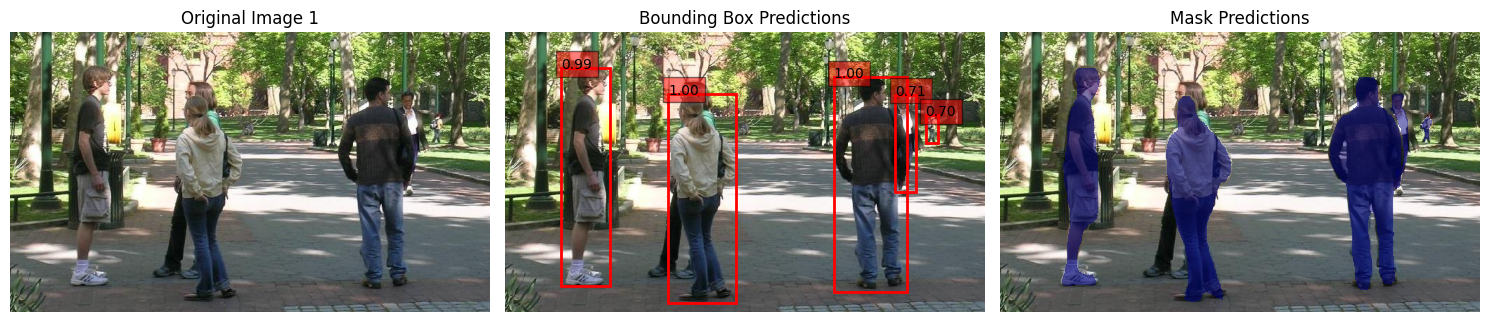


Prediction Scores for Image 1:
Detection 1: 0.997
Detection 2: 0.996
Detection 3: 0.993
Detection 4: 0.710
Detection 5: 0.705


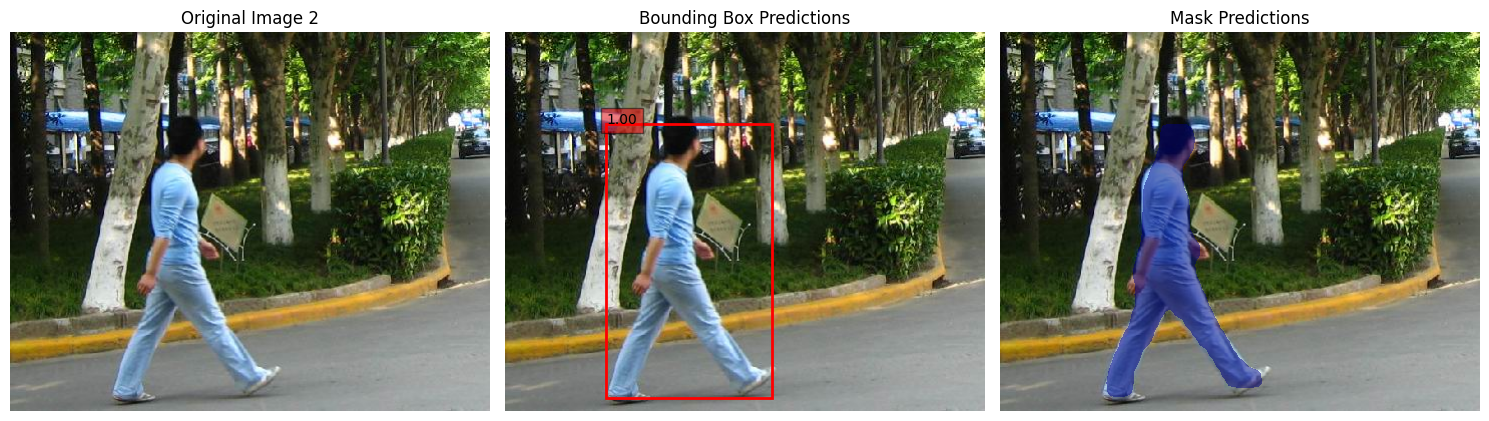


Prediction Scores for Image 2:
Detection 1: 0.996


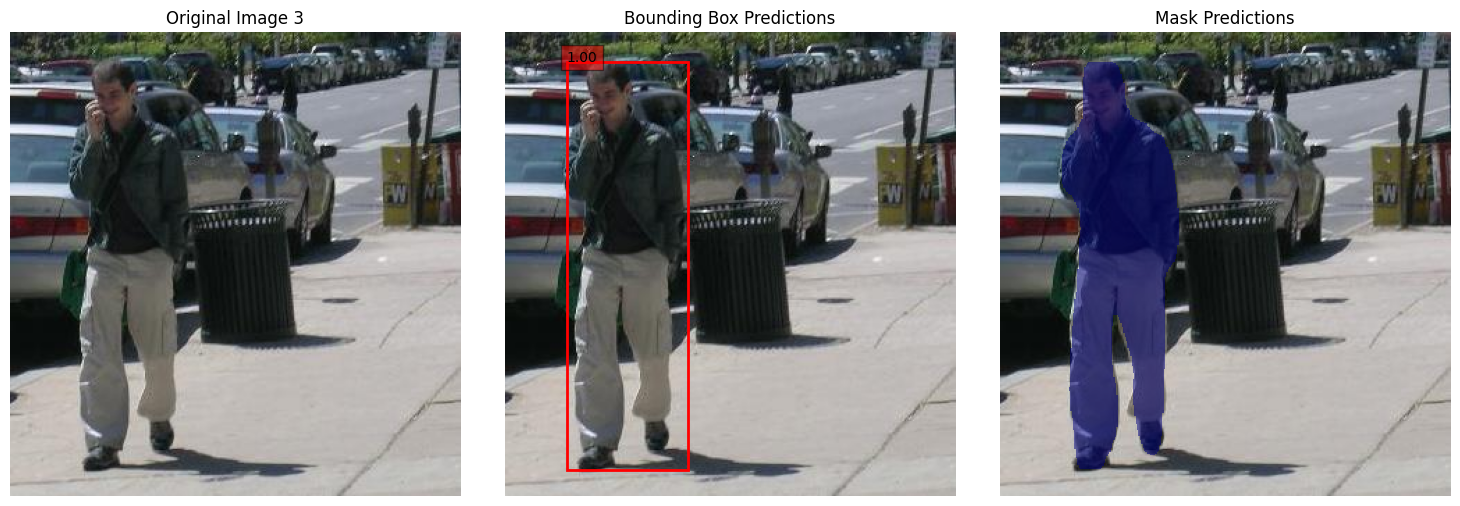


Prediction Scores for Image 3:
Detection 1: 0.996


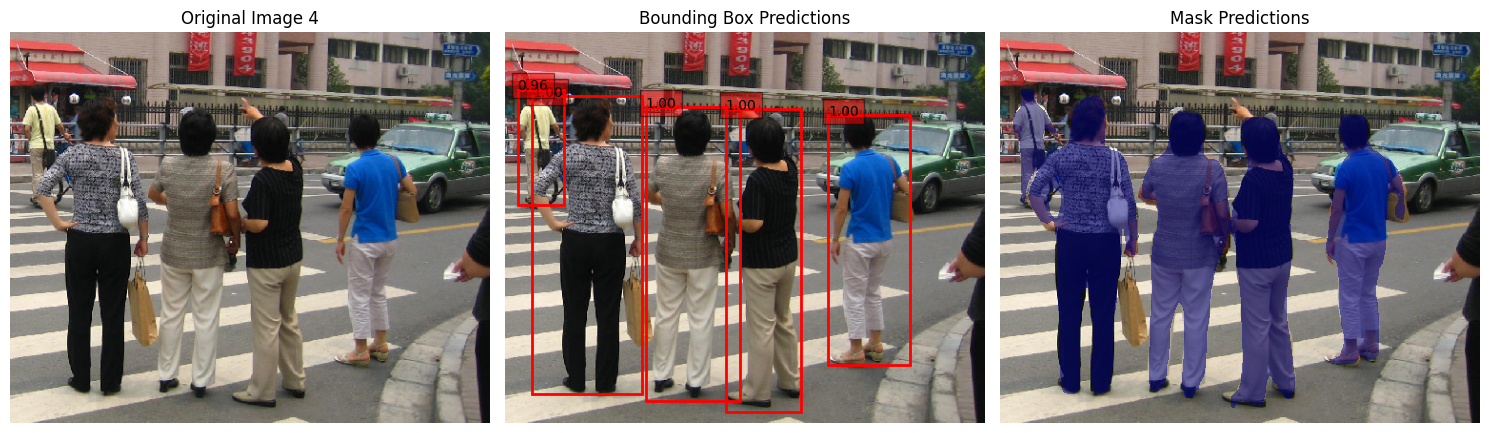


Prediction Scores for Image 4:
Detection 1: 0.997
Detection 2: 0.996
Detection 3: 0.996
Detection 4: 0.996
Detection 5: 0.959


In [ ]:
def visualize_predictions(model, data_loader, device, num_images=1):
    model.eval()

    # Initialize counters
    images_processed = 0
    data_iterator = iter(data_loader)

    while images_processed < num_images:
        try:
            # Get next batch of images
            images, targets = next(data_iterator)
            images = list(img.to(device) for img in images)

            with torch.no_grad():
                predictions = model(images)

            # Process each image in the batch
            for i in range(len(images)):
                if images_processed >= num_images:
                    break

                # Get the original image
                image = images[i].cpu()
                image = image.permute(1, 2, 0)

                # Get predictions for this image
                pred_boxes = predictions[i]['boxes'].cpu()
                pred_masks = predictions[i]['masks'].cpu()
                pred_scores = predictions[i]['scores'].cpu()

                # Create figure with subplots
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

                # Plot original image
                ax1.imshow(image)
                ax1.set_title(f'Original Image {images_processed + 1}')
                ax1.axis('off')

                # Plot image with bounding boxes
                ax2.imshow(image)
                for box, score in zip(pred_boxes, pred_scores):
                    if score > 0.5:
                        x1, y1, x2, y2 = box.numpy()
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          fill=False, color='red', linewidth=2)
                        ax2.add_patch(rect)
                        ax2.text(x1, y1, f'{score:.2f}',
                                bbox=dict(facecolor='red', alpha=0.5))
                ax2.set_title('Bounding Box Predictions')
                ax2.axis('off')

                # Plot image with masks
                ax3.imshow(image)
                for mask, score in zip(pred_masks, pred_scores):
                    if score > 0.5:
                        mask = mask[0] > 0.5
                        masked = np.ma.masked_where(~mask, mask)
                        ax3.imshow(masked, alpha=0.5, cmap='jet')
                ax3.set_title('Mask Predictions')
                ax3.axis('off')

                plt.tight_layout()
                plt.show()

                # Print prediction scores
                print(f"\nPrediction Scores for Image {images_processed + 1}:")
                for j, score in enumerate(pred_scores):
                    if score > 0.5:
                        print(f"Detection {j+1}: {score:.3f}")

                images_processed += 1

        except StopIteration:
            print("\nReached end of dataset")
            break

# Visualize predictions
print("Visualizing predictions...")
visualize_predictions(model, data_loader_test, device, num_images=4)

Step 6: Discussion

Train and evaluate the model by replacing the ROIAlign operator with the ROIPool operator. Compare the mAP results without using **torchvision.ops.RoIPool, and torchvision.ops.roi_pool**.

Training model with ROIAlign...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch 0/60, Loss: 3.8342
Batch 10/60, Loss: 0.4200
Batch 20/60, Loss: 0.4845
Batch 30/60, Loss: 0.4406
Batch 40/60, Loss: 0.2518
Batch 50/60, Loss: 0.4121
Epoch 1
Loss: 0.5348, Box mAP: 0.6961, Mask mAP: 0.6744
Batch 0/60, Loss: 0.2102
Batch 10/60, Loss: 0.3133
Batch 20/60, Loss: 0.2365
Batch 30/60, Loss: 0.1718
Batch 40/60, Loss: 0.1824
Batch 50/60, Loss: 0.1805
Epoch 2
Loss: 0.2657, Box mAP: 0.7464, Mask mAP: 0.7232
Batch 0/60, Loss: 0.1420
Batch 10/60, Loss: 0.2095
Batch 20/60, Loss: 0.2696
Batch 30/60, Loss: 0.2166
Batch 40/60, Loss: 0.3916
Batch 50/60, Loss: 0.1540
Epoch 3
Loss: 0.2302, Box mAP: 0.7534, Mask mAP: 0.7252
Batch 0/60, Loss: 0.1959
Batch 10/60, Loss: 0.2410
Batch 20/60, Loss: 0.2369
Batch 30/60, Loss: 0.1424
Batch 40/60, Loss: 0.2457
Batch 50/60, Loss: 0.1790
Epoch 4
Loss: 0.2003, Box mAP: 0.7969, Mask mAP: 0.7347
Batch 0/60, Loss: 0.1801
Batch 10/60, Loss: 0.1386
Batch 20/60, Loss: 0.2460
Batch 30/60, Loss: 0.1616
Batch 40/60, Loss: 0.1842
Batch 50/60, Loss: 0.2938
E

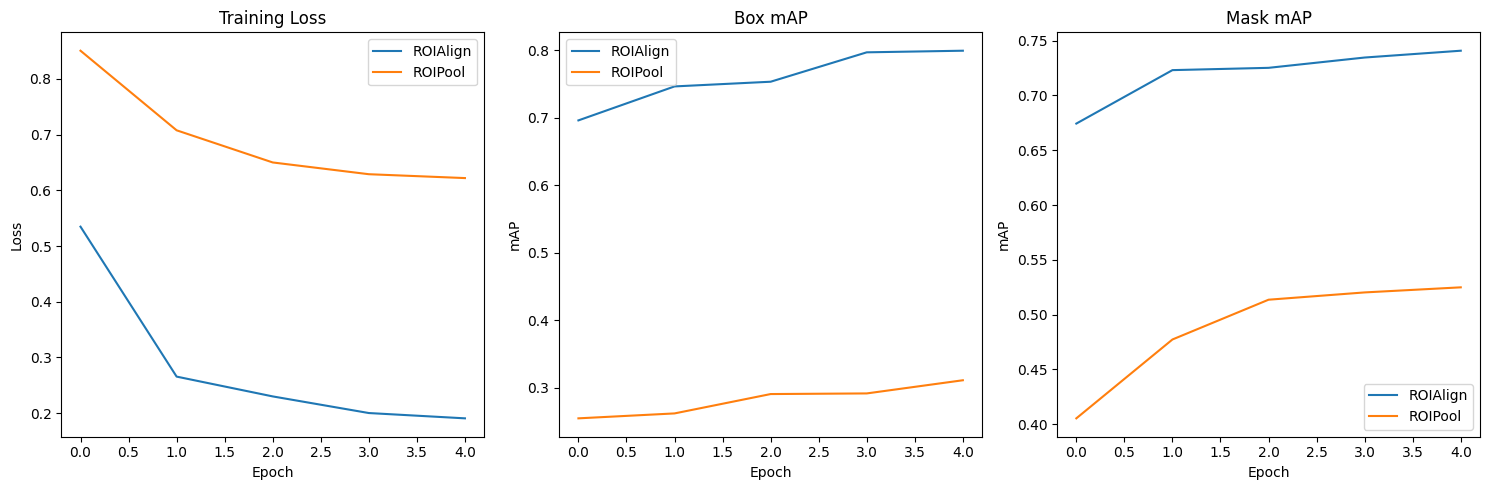


Final Results:

ROIAlign:
Final Box mAP: 0.7993
Final Mask mAP: 0.7409

ROIPool:
Final Box mAP: 0.3109
Final Mask mAP: 0.5249


In [ ]:
class MultiScaleRoIPool(nn.Module):
    def __init__(self, featmap_names, output_size, sampling_ratio):
        super().__init__()
        self.featmap_names = featmap_names
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size

    def convert_to_roi_format(self, boxes):
        concat_boxes = torch.cat(boxes, dim=0)
        device, dtype = concat_boxes.device, concat_boxes.dtype
        ids = torch.cat([
            torch.full_like(b[:, :1], i, dtype=dtype, device=device)
            for i, b in enumerate(boxes)
        ], dim=0)
        rois = torch.cat([ids, concat_boxes], dim=1)
        return rois

    def forward(self, x, boxes, image_shapes):
        num_boxes = [len(box) for box in boxes]
        if not num_boxes:
            return torch.zeros(0, x[self.featmap_names[0]].shape[1],
                             self.output_size[0], self.output_size[1],
                             device=x[self.featmap_names[0]].device)

        rois = self.convert_to_roi_format(boxes)
        aligned_features = []

        for feature_name in self.featmap_names:
            feature_map = x[feature_name]
            h, w = feature_map.shape[-2:]
            scale = torch.tensor([w, h, w, h], device=feature_map.device)
            scaled_rois = rois.clone()
            scaled_rois[:, 1:] = scaled_rois[:, 1:] / scale

            pooled = self.roi_pool(
                feature_map,
                scaled_rois,
                output_size=self.output_size
            )
            aligned_features.append(pooled)

        if len(aligned_features) > 1:
            return torch.mean(torch.stack(aligned_features), dim=0)
        else:
            return aligned_features[0]

    def roi_pool(self, features, rois, output_size):

        num_rois = rois.size(0)
        C = features.size(1)
        H, W = output_size
        device = features.device

        output = features.new_zeros((num_rois, C, H, W))

        for roi_idx in range(num_rois):
            roi = rois[roi_idx]
            batch_idx = int(roi[0])
            x1, y1, x2, y2 = roi[1:]

            x1_int = int(x1.floor())
            y1_int = int(y1.floor())
            x2_int = int(x2.ceil())
            y2_int = int(y2.ceil())

            x1_int = max(0, min(x1_int, features.shape[3]-1))
            y1_int = max(0, min(y1_int, features.shape[2]-1))
            x2_int = max(x1_int+1, min(x2_int, features.shape[3]))
            y2_int = max(y1_int+1, min(y2_int, features.shape[2]))

            roi_width = x2_int - x1_int
            roi_height = y2_int - y1_int
            w_step = roi_width / W
            h_step = roi_height / H

            for i in range(H):
                for j in range(W):
                    start_h = y1_int + int(i * h_step)
                    end_h = min(start_h + int(h_step), y2_int)
                    start_w = x1_int + int(j * w_step)
                    end_w = min(start_w + int(w_step), x2_int)

                    if end_h > start_h and end_w > start_w:
                        roi_feature = features[batch_idx, :, start_h:end_h, start_w:end_w]
                        output[roi_idx, :, i, j] = torch.max(
                            torch.max(roi_feature, dim=-1)[0], dim=-1)[0]

        return output

def compare_roi_operators():
    model_align = get_model_instance_segmentation(num_classes)
    model_pool = get_model_instance_segmentation(num_classes)

    model_pool.roi_heads.box_roi_pool = MultiScaleRoIPool(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    model_align = model_align.to(device)
    model_pool = model_pool.to(device)


    params_align = [p for p in model_align.parameters() if p.requires_grad]
    params_pool = [p for p in model_pool.parameters() if p.requires_grad]

    optimizer_align = torch.optim.SGD(params_align, lr=0.005, momentum=0.9, weight_decay=0.0005)
    optimizer_pool = torch.optim.SGD(params_pool, lr=0.005, momentum=0.9, weight_decay=0.0005)

    lr_scheduler_align = torch.optim.lr_scheduler.StepLR(optimizer_align, step_size=3, gamma=0.1)
    lr_scheduler_pool = torch.optim.lr_scheduler.StepLR(optimizer_pool, step_size=3, gamma=0.1)

    num_epochs = 5

    results = {
        'ROIAlign': {'train_loss': [], 'box_map': [], 'mask_map': []},
        'ROIPool': {'train_loss': [], 'box_map': [], 'mask_map': []}
    }

    print("Training model with ROIAlign...")
    for epoch in range(num_epochs):
        loss = train_one_epoch(model_align, optimizer_align, data_loader, device)
        results['ROIAlign']['train_loss'].append(loss)

        box_map, mask_map = evaluate_predictions(model_align, data_loader_test, device)
        results['ROIAlign']['box_map'].append(box_map)
        results['ROIAlign']['mask_map'].append(mask_map)

        lr_scheduler_align.step()

        print(f"Epoch {epoch+1}")
        print(f"Loss: {loss:.4f}, Box mAP: {box_map:.4f}, Mask mAP: {mask_map:.4f}")

    print("\nTraining model with ROIPool...")
    for epoch in range(num_epochs):

        loss = train_one_epoch(model_pool, optimizer_pool, data_loader, device)
        results['ROIPool']['train_loss'].append(loss)

        box_map, mask_map = evaluate_predictions(model_pool, data_loader_test, device)
        results['ROIPool']['box_map'].append(box_map)
        results['ROIPool']['mask_map'].append(mask_map)

        lr_scheduler_pool.step()

        print(f"Epoch {epoch+1}")
        print(f"Loss: {loss:.4f}, Box mAP: {box_map:.4f}, Mask mAP: {mask_map:.4f}")

    return results,model_align,model_pool


results,model_align,model_pool = compare_roi_operators()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results['ROIAlign']['train_loss'], label='ROIAlign')
plt.plot(results['ROIPool']['train_loss'], label='ROIPool')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(results['ROIAlign']['box_map'], label='ROIAlign')
plt.plot(results['ROIPool']['box_map'], label='ROIPool')
plt.title('Box mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(results['ROIAlign']['mask_map'], label='ROIAlign')
plt.plot(results['ROIPool']['mask_map'], label='ROIPool')
plt.title('Mask mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Results:")
print("\nROIAlign:")
print(f"Final Box mAP: {results['ROIAlign']['box_map'][-1]:.4f}")
print(f"Final Mask mAP: {results['ROIAlign']['mask_map'][-1]:.4f}")
print("\nROIPool:")
print(f"Final Box mAP: {results['ROIPool']['box_map'][-1]:.4f}")
print(f"Final Mask mAP: {results['ROIPool']['mask_map'][-1]:.4f}")

Visualizing ROIAlign vs ROIPool predictions...


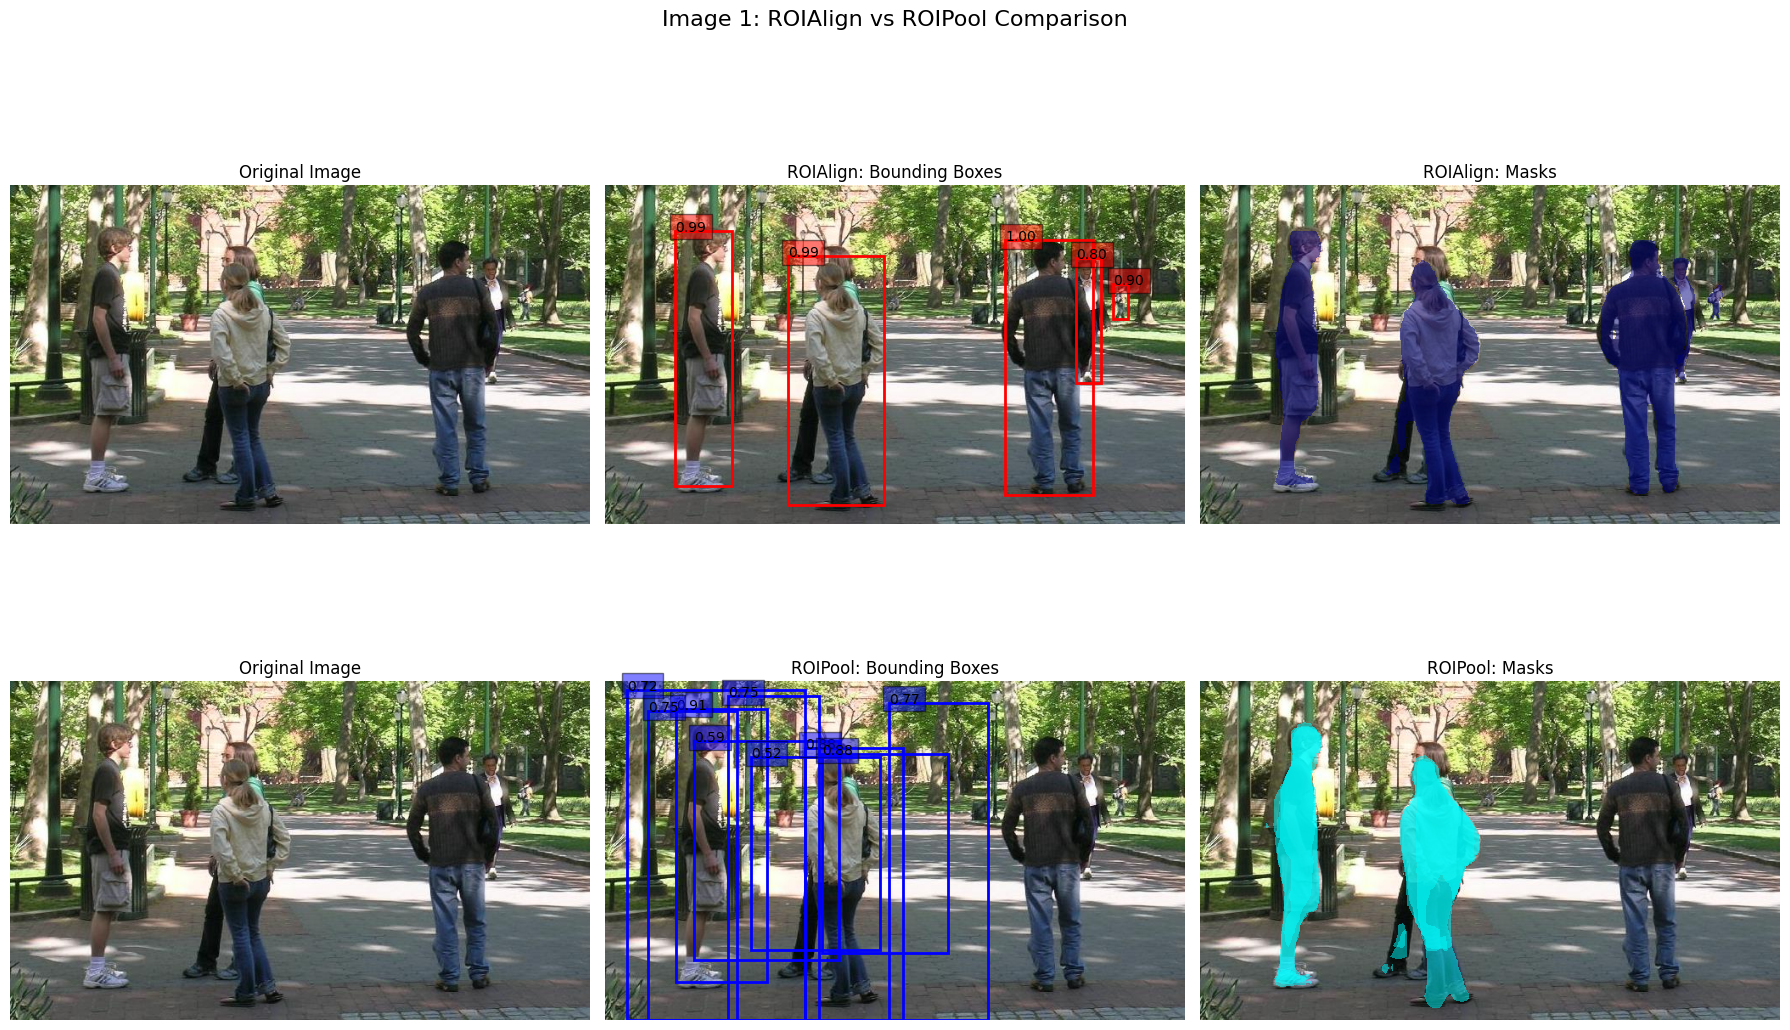


Prediction Scores for Image 1:

ROIAlign Predictions:
Detection 1: 0.997
Detection 2: 0.995
Detection 3: 0.992
Detection 4: 0.897
Detection 5: 0.801

ROIPool Predictions:
Detection 1: 0.911
Detection 2: 0.880
Detection 3: 0.876
Detection 4: 0.771
Detection 5: 0.751
Detection 6: 0.746
Detection 7: 0.724
Detection 8: 0.589
Detection 9: 0.517


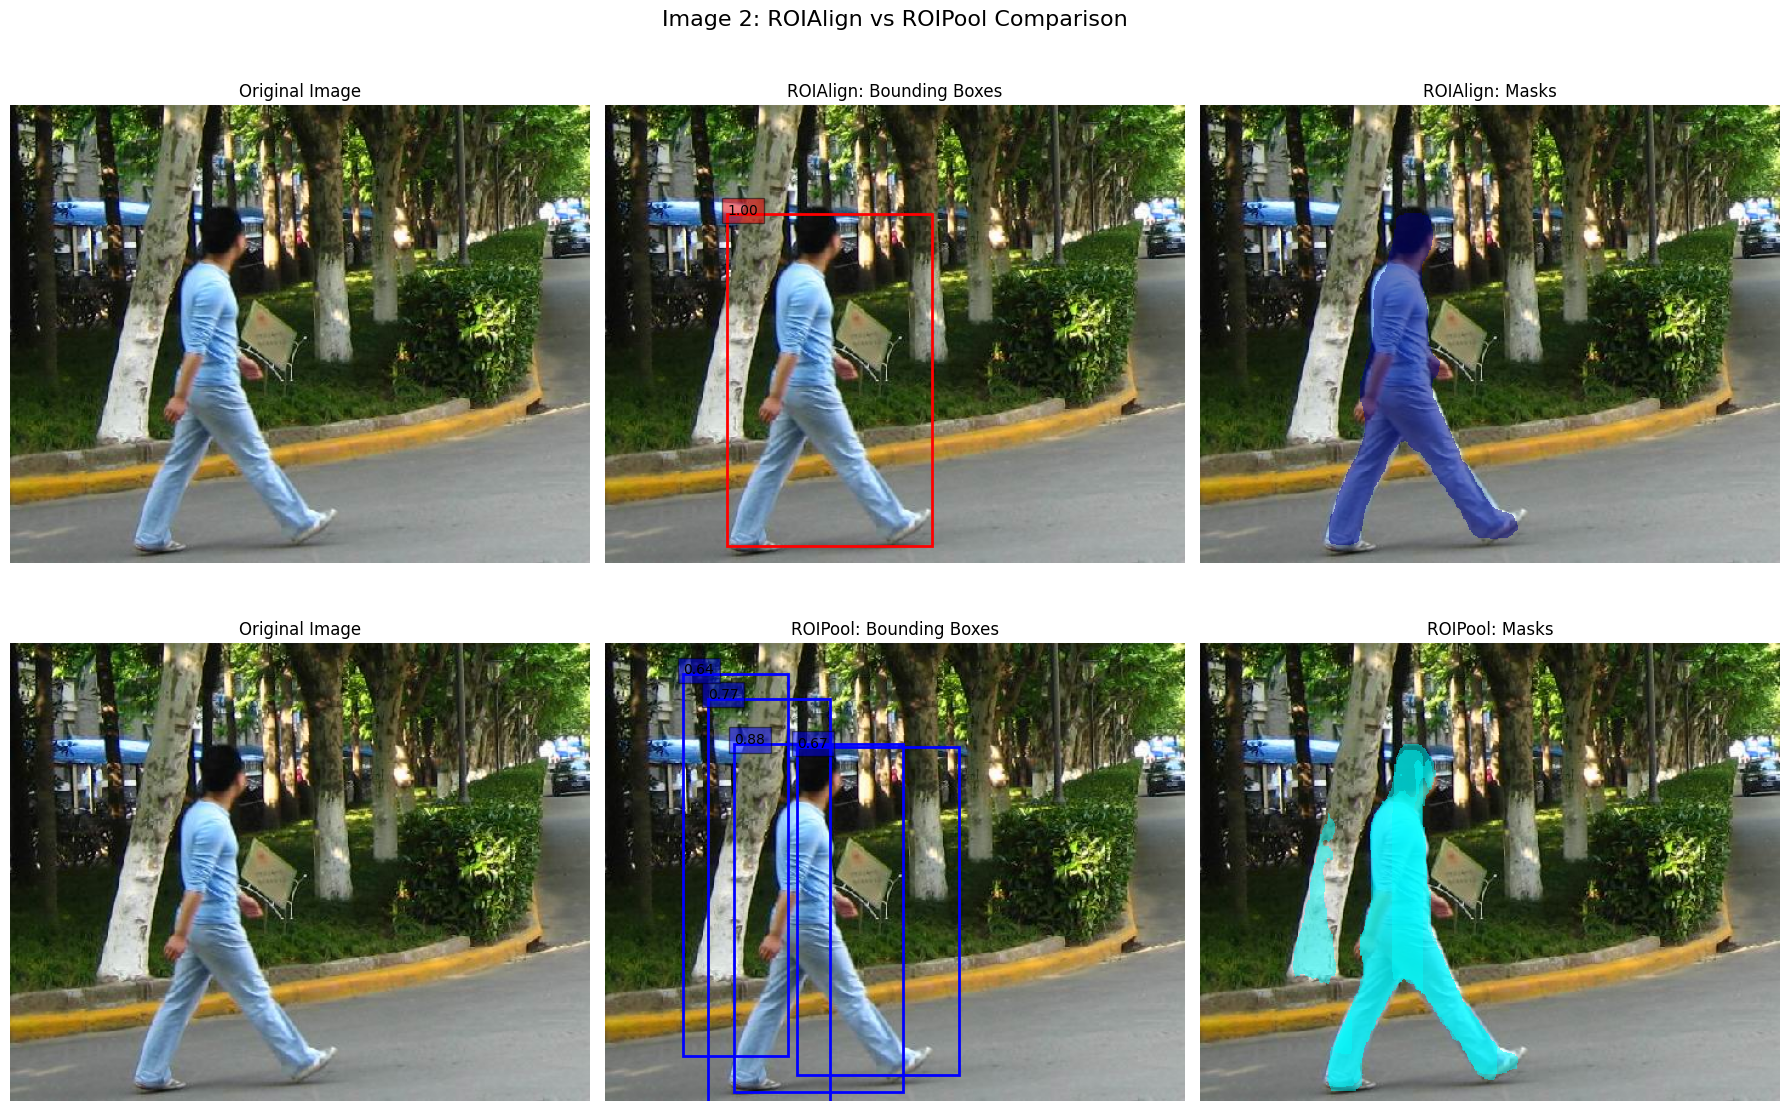


Prediction Scores for Image 2:

ROIAlign Predictions:
Detection 1: 0.995

ROIPool Predictions:
Detection 1: 0.883
Detection 2: 0.767
Detection 3: 0.666
Detection 4: 0.645


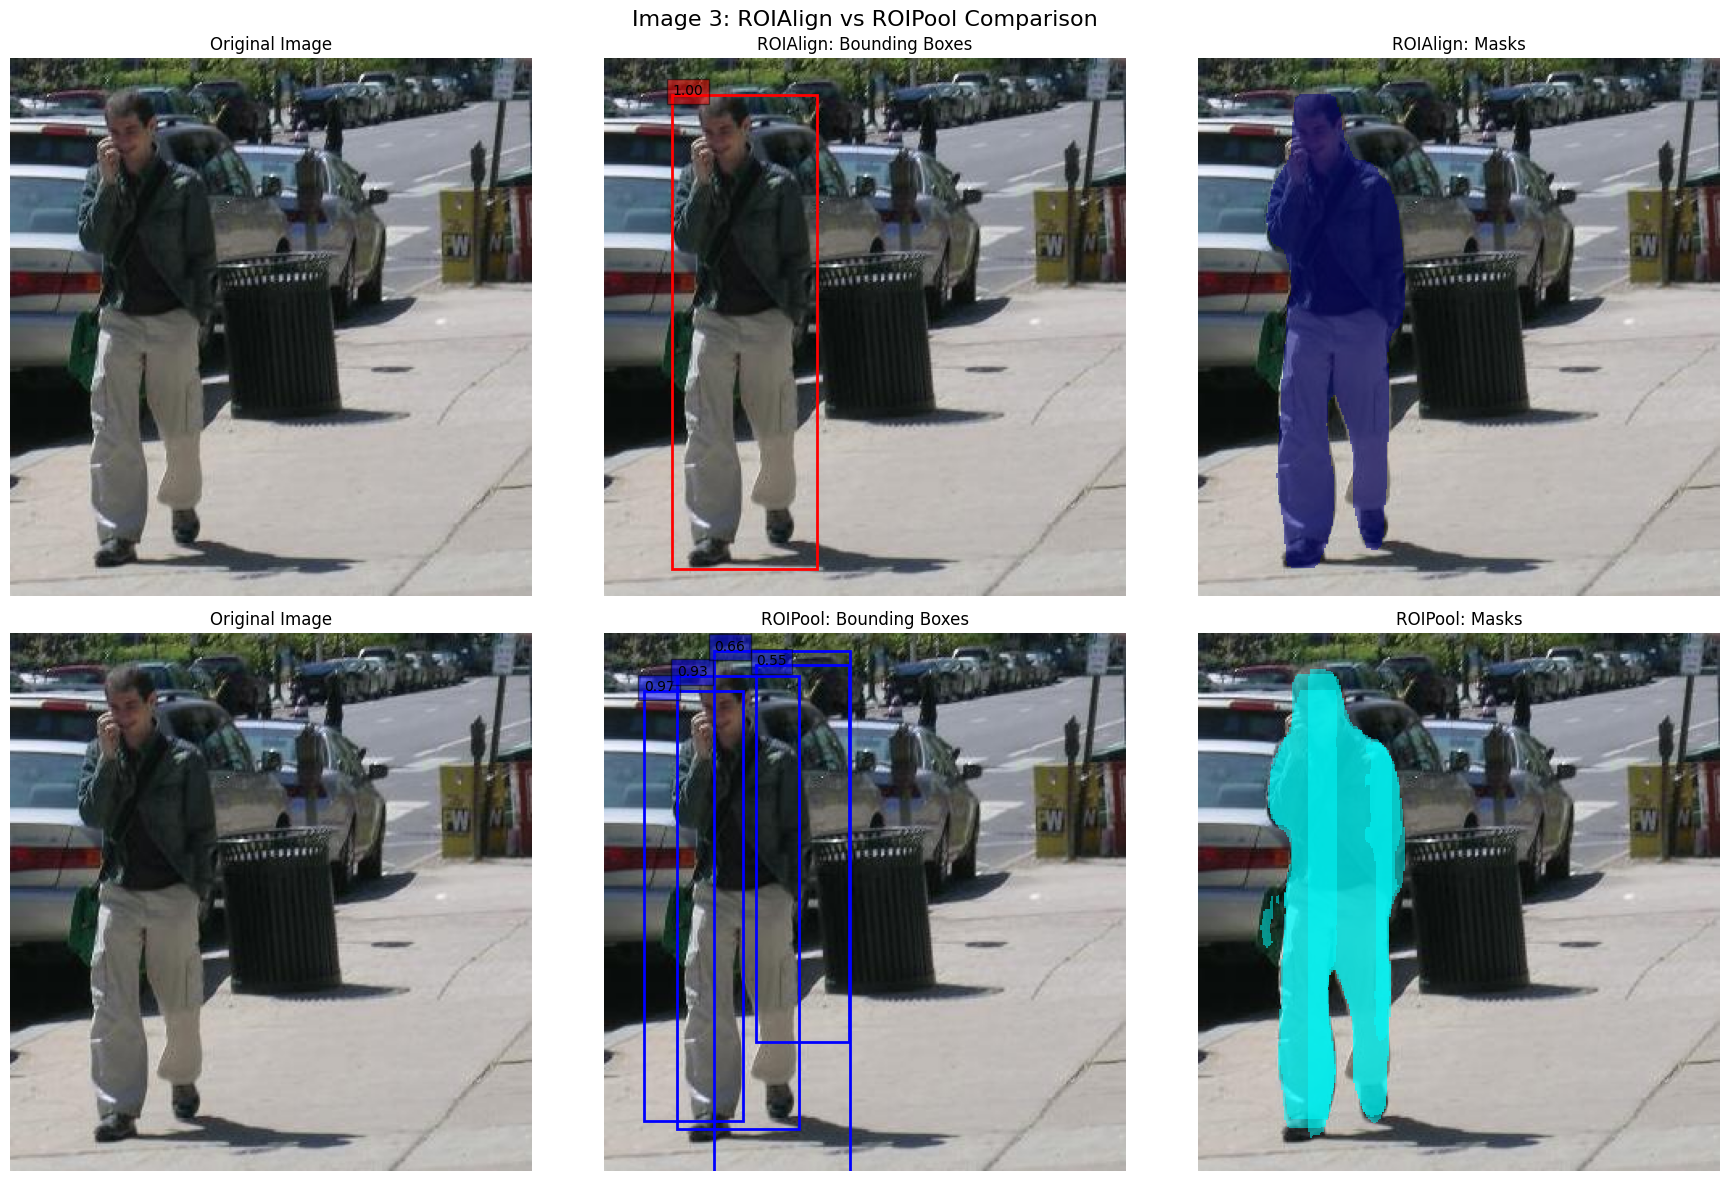


Prediction Scores for Image 3:

ROIAlign Predictions:
Detection 1: 0.997

ROIPool Predictions:
Detection 1: 0.967
Detection 2: 0.930
Detection 3: 0.656
Detection 4: 0.549


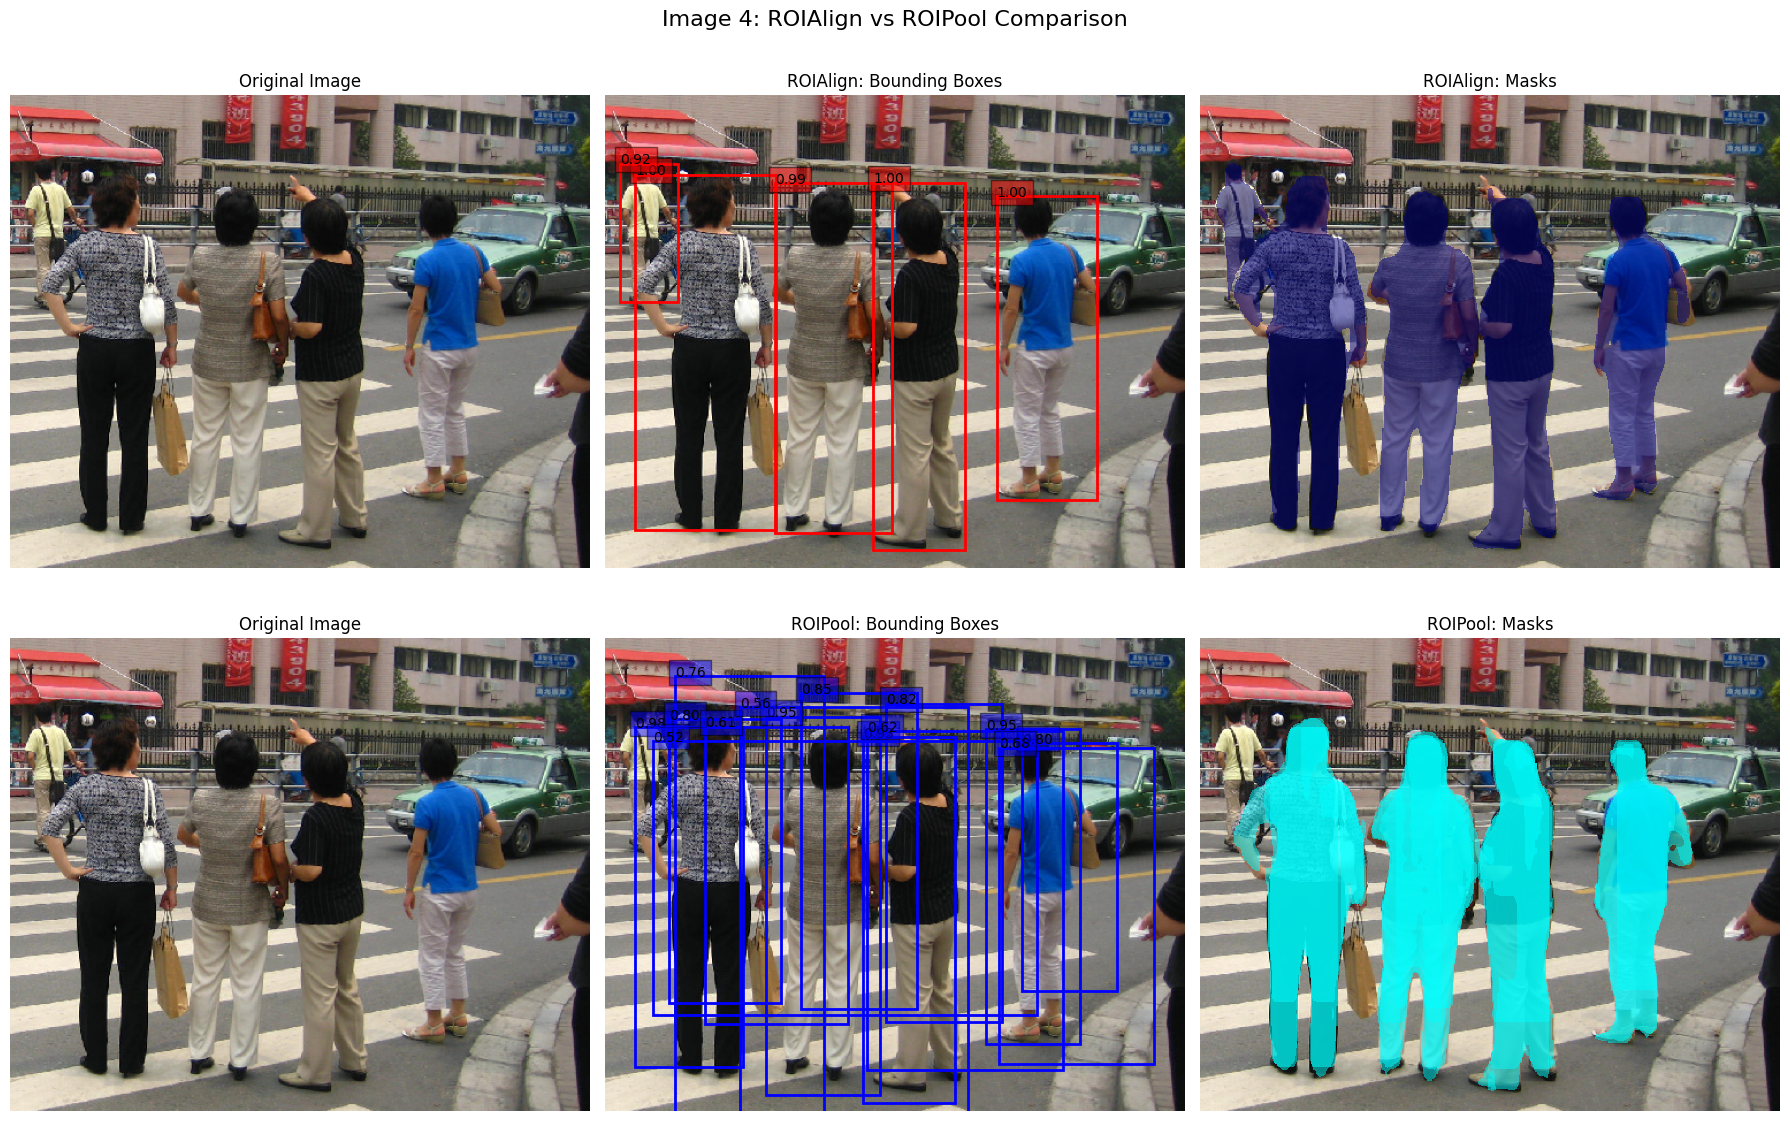


Prediction Scores for Image 4:

ROIAlign Predictions:
Detection 1: 0.997
Detection 2: 0.997
Detection 3: 0.995
Detection 4: 0.992
Detection 5: 0.922

ROIPool Predictions:
Detection 1: 0.975
Detection 2: 0.953
Detection 3: 0.948
Detection 4: 0.931
Detection 5: 0.850
Detection 6: 0.820
Detection 7: 0.805
Detection 8: 0.799
Detection 9: 0.764
Detection 10: 0.681
Detection 11: 0.617
Detection 12: 0.613
Detection 13: 0.565
Detection 14: 0.522


In [ ]:
def visualize_roi_comparison(model_align, model_pool, data_loader, device, num_images=1):
    """
    Visualize and compare predictions from ROIAlign and ROIPool models
    """
    model_align.eval()
    model_pool.eval()

    # Initialize counters
    images_processed = 0
    data_iterator = iter(data_loader)

    while images_processed < num_images:
        try:
            # Get next batch of images
            images, targets = next(data_iterator)
            images = list(img.to(device) for img in images)

            with torch.no_grad():
                # Get predictions from both models
                predictions_align = model_align(images)
                predictions_pool = model_pool(images)

            # Process each image in the batch
            for i in range(len(images)):
                if images_processed >= num_images:
                    break

                # Get the original image
                image = images[i].cpu()
                image = image.permute(1, 2, 0)

                # Get predictions for this image from both models
                pred_boxes_align = predictions_align[i]['boxes'].cpu()
                pred_masks_align = predictions_align[i]['masks'].cpu()
                pred_scores_align = predictions_align[i]['scores'].cpu()

                pred_boxes_pool = predictions_pool[i]['boxes'].cpu()
                pred_masks_pool = predictions_pool[i]['masks'].cpu()
                pred_scores_pool = predictions_pool[i]['scores'].cpu()

                # Create figure with subplots
                fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                plt.suptitle(f'Image {images_processed + 1}: ROIAlign vs ROIPool Comparison', fontsize=16)

                # ROIAlign results (top row)
                # Original image
                axes[0,0].imshow(image)
                axes[0,0].set_title('Original Image')
                axes[0,0].axis('off')

                # Bounding boxes with ROIAlign
                axes[0,1].imshow(image)
                for box, score in zip(pred_boxes_align, pred_scores_align):
                    if score > 0.5:
                        x1, y1, x2, y2 = box.numpy()
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          fill=False, color='red', linewidth=2)
                        axes[0,1].add_patch(rect)
                        axes[0,1].text(x1, y1, f'{score:.2f}',
                                     bbox=dict(facecolor='red', alpha=0.5))
                axes[0,1].set_title('ROIAlign: Bounding Boxes')
                axes[0,1].axis('off')

                # Masks with ROIAlign
                axes[0,2].imshow(image)
                for mask, score in zip(pred_masks_align, pred_scores_align):
                    if score > 0.5:
                        mask = mask[0] > 0.5
                        masked = np.ma.masked_where(~mask, mask)
                        axes[0,2].imshow(masked, alpha=0.5, cmap='jet')
                axes[0,2].set_title('ROIAlign: Masks')
                axes[0,2].axis('off')

                # ROIPool results (bottom row)
                # Original image
                axes[1,0].imshow(image)
                axes[1,0].set_title('Original Image')
                axes[1,0].axis('off')

                # Bounding boxes with ROIPool
                axes[1,1].imshow(image)
                for box, score in zip(pred_boxes_pool, pred_scores_pool):
                    if score > 0.5:
                        x1, y1, x2, y2 = box.numpy()
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          fill=False, color='blue', linewidth=2)
                        axes[1,1].add_patch(rect)
                        axes[1,1].text(x1, y1, f'{score:.2f}',
                                     bbox=dict(facecolor='blue', alpha=0.5))
                axes[1,1].set_title('ROIPool: Bounding Boxes')
                axes[1,1].axis('off')

                # Masks with ROIPool
                axes[1,2].imshow(image)
                for mask, score in zip(pred_masks_pool, pred_scores_pool):
                    if score > 0.5:
                        mask = mask[0] > 0.5
                        masked = np.ma.masked_where(~mask, mask)
                        axes[1,2].imshow(masked, alpha=0.5, cmap='cool')
                axes[1,2].set_title('ROIPool: Masks')
                axes[1,2].axis('off')

                plt.tight_layout()
                plt.show()

                # Print prediction scores
                print(f"\nPrediction Scores for Image {images_processed + 1}:")
                print("\nROIAlign Predictions:")
                for j, score in enumerate(pred_scores_align):
                    if score > 0.5:
                        print(f"Detection {j+1}: {score:.3f}")

                print("\nROIPool Predictions:")
                for j, score in enumerate(pred_scores_pool):
                    if score > 0.5:
                        print(f"Detection {j+1}: {score:.3f}")

                images_processed += 1

        except StopIteration:
            print("\nReached end of dataset")
            break

# Visualize predictions from both models
print("Visualizing ROIAlign vs ROIPool predictions...")

visualize_roi_comparison(model_align, model_pool, data_loader_test, device, num_images=4)

<!-- Step 6: Discussion

Train and evaluate the detection performance of the model by replacing the ROIAlign operator with the ROIPool operator. Compare the results without using **torchvision.ops.RoIPool, and torchvision.ops.roi_pool**. -->